<a href="https://colab.research.google.com/github/AnusreeChittineni/VAIL_2021/blob/main/Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# unzips neccessarry zip files in Drive
# only needs to be run once for your Drive
!unzip -uq "/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json.zip" -d "/content/drive/My Drive/SarcasmDetection"

In [1]:
import json

# reading data
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

# intializes a list called data to store data
data = list(parse_data('/content/drive/MyDrive/SarcasmDetection/Sarcasm_Headlines_Dataset.json'))
print(data[0])

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [2]:
# imports pandas database
import pandas as pd

# intializes pandas dataframe to store data
df = pd.DataFrame(data)
print(df.head())

                                        article_link  ... is_sarcastic
0  https://www.huffingtonpost.com/entry/versace-b...  ...            0
1  https://www.huffingtonpost.com/entry/roseanne-...  ...            0
2  https://local.theonion.com/mom-starting-to-fea...  ...            1
3  https://politics.theonion.com/boehner-just-wan...  ...            1
4  https://www.huffingtonpost.com/entry/jk-rowlin...  ...            0

[5 rows x 3 columns]


In [3]:
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import numpy as np

In [35]:
# initlaizes input and output values
x = df['headline'].values
y = df['is_sarcastic'].values

# splits data into training and testing groups
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size=0.50)

# prints shape of data
print(x_train.shape, x_test.shape, x_validate.shape, y_train.shape, y_test.shape, y_validate.shape)

(18696,) (4006,) (4007,) (18696,) (4006,) (4007,)


In [40]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train) 

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
max_sequence_train = max(len(x) for x in training_sequences)
training_padded = np.array([np.pad(x, (0, max_sequence_train - len(x))) for x in training_sequences])

val_sequences = tokenizer.texts_to_sequences(x_validate)
max_sequence_val = max(len(x) for x in val_sequences)
val_padded = np.array([np.pad(x, (0, max_sequence_val - len(x))) for x in val_sequences])

testing_sequences = tokenizer.texts_to_sequences(x_test)
max_sequence_test = max(len(x) for x in testing_sequences)
testing_padded = np.array([np.pad(x, (0, max_sequence_test - len(x))) for x in testing_sequences])

#y_test = np.array(y_test)

In [38]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index) + 1, 2, input_shape=[None]),
        tf.keras.layers.LSTM(2, return_sequences=True),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           49554     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 2)           40        
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           3         
Total params: 49,597
Trainable params: 49,597
Non-trainable params: 0
_________________________________________________________________


In [47]:
# try with various optimizer and loss algorithms
# (SGD, MSE, 56), (Adam, MSE, 93), (Adam, BC, 97)
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])

history = model.fit(training_padded, y_train, validation_data=(val_padded, y_validate), 
          epochs=15, verbose=0)

Epoch 1/15
585/585 [==============================] - 14s 20ms/step - loss: 0.0943 - accuracy: 0.9750 - val_loss: 0.6031 - val_accuracy: 0.8431
Epoch 2/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.6189 - val_accuracy: 0.8437
Epoch 3/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0799 - accuracy: 0.9787 - val_loss: 0.6599 - val_accuracy: 0.8399
Epoch 4/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0745 - accuracy: 0.9798 - val_loss: 0.6666 - val_accuracy: 0.8417
Epoch 5/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0698 - accuracy: 0.9808 - val_loss: 0.7050 - val_accuracy: 0.8378
Epoch 6/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0619 - accuracy: 0.9827 - val_loss: 0.7351 - val_accuracy: 0.8374
Epoch 7/15
585/585 [==============================] - 12s 20ms/step - loss: 0.0565 - accuracy: 0.9840 - val_loss: 0.7558 - val_accuracy:

In [50]:
results = model.evaluate(testing_padded, y_test)
print("test loss, test acc:", results)

predictions = model.predict(testing_padded)
#print(predictions)

# I don't understand why this line of code does not work
# print(sklearn.metrics.accuracy_score(y_test, predictions, normalize=False))

126/126 [==============================] - 0s 3ms/step - loss: 0.9157 - accuracy: 0.8076
test loss, test acc: [0.9156700968742371, 0.8075758814811707]


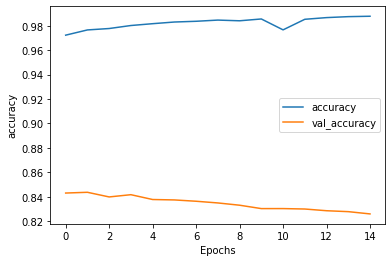

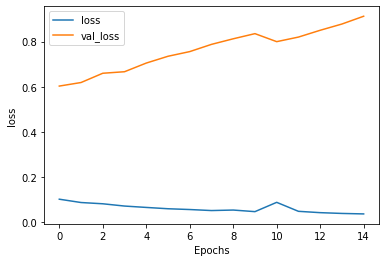

In [49]:
import matplotlib.pyplot as plt

def plot_data(model_history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_data(history, "accuracy")
plot_data(history, "loss")
